## Exercise 8: Blobs and SIFT features


These exercises will introduce you to blobs and SIFT features. In this exercise you will write the code for the blob detector as well as use the SIFT feature detector and matcher.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Blob detector

You will implement a blob detector using the **Difference-of-Gaussian (DoG)** method and apply it to the following image of sunflowers.
Start by loading the image into Python, and converting it to black and white and floating point.



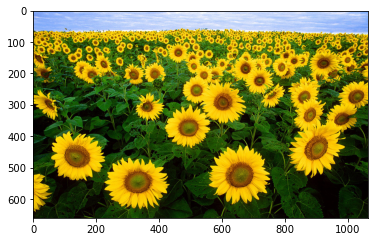

In [2]:
img = plt.imread("sunflowers.JPG")
plt.imshow(img)
plt.show()

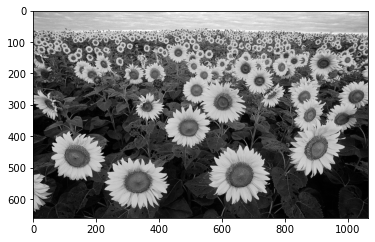

Image size: (660, 1066)


In [3]:
R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
plt.imshow(imgGray, cmap='gray')
plt.show()

rc=np.shape(imgGray)
print('Image size:',rc)

- **Exercise 8.1**. Create the function `im_scales = scaleSpaced(im, sigma, n)`, where `im_scales` is a scale pyramid of the original image `im`. The width and height of all images in the pyramid `im_scales` are exactly the same as the original image `im`. In other words `im_scales` is not a pyramid in image sizes; only in scale space.
This function should apply a Gaussian kernel of width $sigma · 2^i$, where i = 0, 1, . . . , 
n − 1.


In [4]:
def gaussian1DKernel(sigma):
    h=np.ceil(4*sigma)
    x = np.arange(-h,h+1)
    g= 1/(sigma*np.sqrt(2*np.pi))*np.exp(-x**2/(2*sigma**2))

    g=g.reshape(-1,1)
    
    return g

In [5]:
def scaleSpaced(im, sigma, n):
    im_scales=[]
    
    for i in range(n):
        g=gaussian1DKernel(sigma*2**i)
        pyram=cv2.filter2D(cv2.filter2D(im,-1,kernel=g),-1,kernel=g.T)
        im_scales.append(pyram)

    return im_scales

(660, 1066)


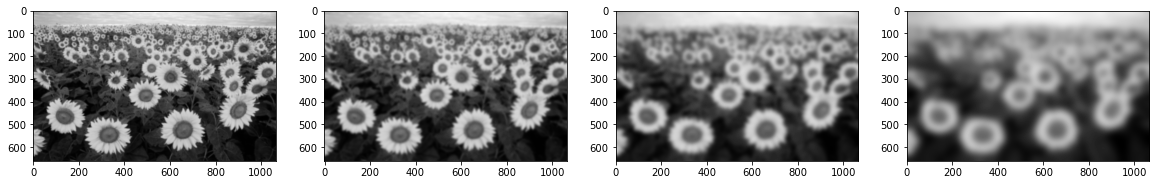

In [6]:
im_scales=scaleSpaced(imgGray, 2, 4)


fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(20,17))
ax1.imshow(im_scales[0],cmap='gray');
ax2.imshow(im_scales[1],cmap='gray');
ax3.imshow(im_scales[2],cmap='gray');
ax4.imshow(im_scales[3],cmap='gray');

print(im_scales[3].shape) #Same scale as the original image. 

- **Exercise 8.2**. Now, create the function `DoG = differenceOfGaussian(im, sigma, n)`, where `DoG` is the scale space DoGs of the original image `im`. Like the scaleSpaced function, the returned images are all the same size as the original.

In [7]:
def differenceOfGaussian(im, sigma, n):
    
    DoGs=[]
    im_scales=scaleSpaced(im,sigma, n)
    
    for ind in range(len(im_scales)-1):
        DoG= im_scales[ind+1]-im_scales[ind]
        DoGs.append(DoG)
        
    return DoGs


(660, 1066)


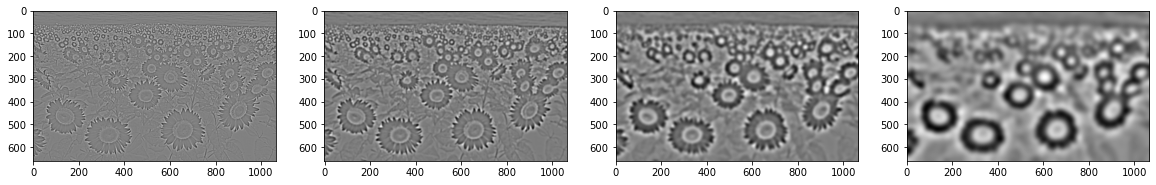

In [8]:
DoGs=differenceOfGaussian(imgGray, sigma=1.5, n=5)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(20,17))
ax1.imshow(DoGs[0],cmap='gray');
ax2.imshow(DoGs[1],cmap='gray');
ax3.imshow(DoGs[2],cmap='gray');
ax4.imshow(DoGs[3],cmap='gray');


print(DoGs[2].shape) #Same scale as the original image. 

- **Exercise 8.3**. Finally, create the function `blobs = detectBlobs(im, sigma, n, threshold)`, where `blobs` are the blobs (pixels) of the original image `im` with a DoG larger than a threshold. You should also implement non-maximum suppression to increase the robustness of the detector.

    Try the detector on the image of sunflowers. Visualize your result by drawing a circle for each image, with the radius proportional to the scale of the blob. You can use cv2.circle for this.


In [9]:
def detectBlobs(im, sigma, n, threshold):
    blobs=[]
    DoGs=differenceOfGaussian(im, sigma=1.5, n=5)
    for ind,i in enumerate(DoGs):
        a=i>threshold
        blobs.append(a)

    return DoGs,blobs

In [10]:
DoGs,blobs=detectBlobs(imgGray, sigma=1.5, n=4, threshold=5)


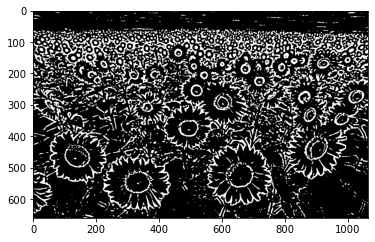

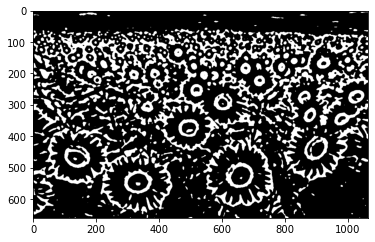

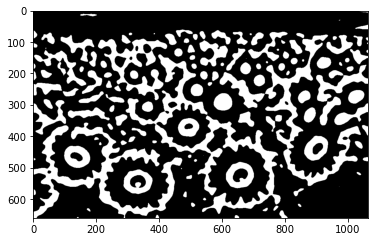

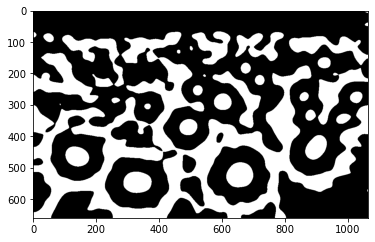

In [11]:
for i,blob in enumerate(blobs):
    plt.imshow(blob,cmap='gray')
    plt.show()
    
    sigma=2
    s=sigma*2**i #scale, radius of the cirlce
    
    coordinates=np.argwhere(blob == True)
    x=[]
    for aa in coordinates:
        x.append((aa[0],aa[1]))
    



### Using SIFT features

The SIFT feature detector and matcher are quite difficult to implement, so we will use existing implementations. However, first we need a good test case scenario.



- **Exercise 8.4**. Create the function `r_im = transformIm(im, theta, s)`, where `r_im` is a scaled and rotated version of the original image `im`. In this case, `theta` is a rotation angle and `s` is a scale factor.
Use this function to produce a transformed version of the test image r_im3.


In [12]:
import cv2
import imutils


def transformIm(im, theta,s):
    
    rot = imutils.rotate(im, angle=theta)
    r_im=cv2.resize(rot,None,fx=s, fy=s,interpolation = cv2.INTER_LINEAR)

    return r_im

In [13]:
im=cv2.imread("sunflowers.JPG")
R, G, B = im[:,:,0], im[:,:,1], im[:,:,2]
imgG = 0.2989 * R + 0.5870 * G + 0.1140 * B

r_im=transformIm(imgG, 40,1.2)
print('Size of the scaled and rotated version:',r_im.shape)
print('Size of the original image:',imgG.shape)

Size of the scaled and rotated version: (792, 1279)
Size of the original image: (660, 1066)


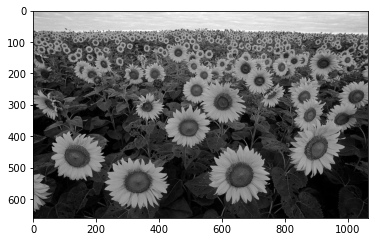

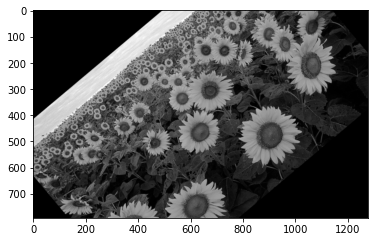

In [14]:
plt.imshow(imgG,cmap='gray')
plt.show()

plt.imshow(r_im,cmap='gray')
plt.show()

- **Exercise 8.5**. Use the SIFT detector to detect features in both the original and the transformed image. Plot the features on top of the images. There are quite a few parameters to play with. Try changing them and see the results.

    Now match the features to each other. For this you can use `cv2.BFMatcher()`. Plot the matches; do they look qualitatively correct?
    Filter your matches with the ratio test. Does this remove incorrect matches?



In [36]:
img1=imgG.astype('uint8') #original image
img2=r_im.astype('uint8') #transformed image

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.2*n.distance:
        good.append([m])
        
print('Number of matches:',len(matches))
print('Number of good matches:',len(good))

Number of matches: 7141
Number of good matches: 509


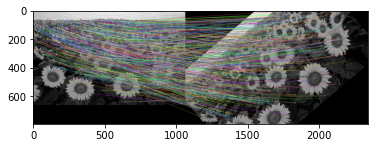

In [37]:
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2,good,img2,flags=2)
plt.imshow(img3)
plt.show()

- **Exercise 8.6**. Take two photos of the same scene from different angles using e.g. your smartphone and find matching SIFT features.


- **Exercise 8.7**. This is an optional exercise. Try downloading R2D2 and use it to match features in your images.

